In [13]:
# NumPy and Pandas for
import numpy as np
import pandas as pd
import seaborn as sns
import openpyxl

#feature selection
from sklearn.linear_model import LogisticRegression as logit # use build-in logistic regression model in sklearn
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_curve, precision_recall_curve


# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

# PyTorch package and submodules
import torch
import torch.nn as nn
from torch.optim import SGD

# We use AUROC and average precision (AP) scores from sklearn
from sklearn.metrics import roc_auc_score, average_precision_score

# Support Vector Classifier
from sklearn.svm import SVC

# Tools in sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
# f1 score
from sklearn.metrics import f1_score
#virtualization of the trees
from sklearn.tree import export_graphviz
import graphviz

# gradient boosting tree model
from xgboost import XGBClassifier as XGBC

# To save the models
from google.colab import files
import pickle



then we import the data

In [76]:
file_path_validation = '/content/drive/MyDrive/ColabData/validation.csv'
file_path_test = '/content/drive/MyDrive/ColabData/test.csv'
file_path_train = '/content/drive/MyDrive/ColabData/train.csv'


In [107]:
# in case we want to use balanced data

file_path_validation = '/content/drive/MyDrive/ColabData/validation_bal.csv'
file_path_test = '/content/drive/MyDrive/ColabData/test_bal.csv'
file_path_train = '/content/drive/MyDrive/ColabData/train_bal.csv'


In [108]:

df_validation = pd.read_csv(file_path_validation)
df_test = pd.read_csv(file_path_test)
df_train = pd.read_csv(file_path_train)


#### Dataframe conversion

In [109]:

#convert the subset to a numpy array
parameter_train = df_train.iloc[:, 4:197]
parameter_validation = df_validation.iloc[:, 4:197]
parameter_test = df_test.iloc[:, 4:197]

label_train = df_train.iloc[:, 3]
label_validation = df_validation.iloc[:, 3]
label_test = df_test.iloc[:, 3]

#convert to pytorch tensor
x_parameter_train = torch.tensor(parameter_train.to_numpy(), dtype=torch.float32)
x_parameter_validation = torch.tensor(parameter_validation.to_numpy(), dtype=torch.float32)
x_parameter_test = torch.tensor(parameter_test.to_numpy(), dtype=torch.float32)

m_train,n_train = x_parameter_train.shape
m_validation,n_validation = x_parameter_validation.shape
m_test,n_test = x_parameter_test.shape

#convert and reshape the y
y_label_train = torch.tensor(label_train.to_numpy(), dtype=torch.float32).reshape(m_train,1)
y_label_validation = torch.tensor(label_validation.to_numpy(), dtype=torch.float32).reshape(m_validation,1)
y_label_test = torch.tensor(label_test.to_numpy(), dtype=torch.float32).reshape(m_test,1)



In [ ]:
round(parameter_train.apply(parameter_train.corrwith),2)
# most parameters are not correlated

In [6]:
print(parameter_train.shape)
print(parameter_train.head(3))

(28075, 193)
   admission_age  heart_rate_min  heart_rate_max  heart_rate_mean   sbp_min  \
0       0.029568        0.468703       -0.365940         0.105523 -0.697981   
1       1.142087        0.534745        4.858321         1.081850 -0.128211   
2      -0.949116       -0.918186       -1.195963        -1.293582  0.042719   

    sbp_max  sbp_mean   dbp_min   dbp_max  dbp_mean  ...  \
0 -0.889936 -1.291165 -0.369306 -0.374445 -0.556268  ...   
1  0.077640  0.194021  0.822822  1.709309  0.541304  ...   
2  0.077640 -0.019854 -0.199002 -0.730208 -0.399565  ...   

   race_TIVE HAWAIIAN OR OTHER PACIFIC ISLANDER  race_UNABLE TO OBTAIN  \
0                                             0                      0   
1                                             0                      0   
2                                             0                      0   

   race_UNKNOWN  race_WHITE  race_WHITE - BRAZILIAN  \
0             0           1                       0   
1             0       

#### Basic logistic regression (full)

In [ ]:
h = torch.nn.Linear(
    in_features=n_train,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f = torch.nn.Sequential(
    h,
    sigma
)

J_BCE = torch.nn.BCELoss()
GD_optimizer = torch.optim.Adam(lr=0.01,params=f.parameters())

nIter = 50000
printInterval = 1000

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f(x_parameter_train)
    loss = J_BCE(pred,y_label_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f(x_parameter_test)

auroc = roc_auc_score(y_label_test,pred_test)
ap = average_precision_score(y_label_test,pred_test)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

#### Logistic Regression with  𝐿1  Regularization (full)

In [55]:
h_L1 = torch.nn.Linear(
    in_features=n_train,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()
f_L1 = torch.nn.Sequential(
    h_L1,
    sigma
    )

J_BCE = torch.nn.BCELoss()


# Define L_1 regularization
def L1_reg(model,lbd):
    result = torch.tensor(0)
    for param in model.parameters(): # iterate over all parameters of our model
        result = result + param.abs().sum()

    return lbd*result

nIter = 4000
printInterval = 1000
lbd_values = [0.075, 0.05, 0.03, 0.01, 0.005, 0.001]  # L1 reg strength values to try

results = []  # To store the summary results
weights_data = []  # To collect weights for each run for DataFrame

Run 1, Lbd 0.075, Iter 1: average BCE loss is 1.218
Run 1, Lbd 0.075, Iter 1000: average BCE loss is 0.699
Run 1, Lbd 0.075, Iter 2000: average BCE loss is 0.700
Run 1, Lbd 0.075, Iter 3000: average BCE loss is 0.700
Run 1, Lbd 0.075, Iter 4000: average BCE loss is 0.699
Run 2, Lbd 0.075, Iter 1: average BCE loss is 1.233
Run 2, Lbd 0.075, Iter 1000: average BCE loss is 0.700
Run 2, Lbd 0.075, Iter 2000: average BCE loss is 0.698
Run 2, Lbd 0.075, Iter 3000: average BCE loss is 0.700
Run 2, Lbd 0.075, Iter 4000: average BCE loss is 0.700
Run 3, Lbd 0.075, Iter 1: average BCE loss is 1.220
Run 3, Lbd 0.075, Iter 1000: average BCE loss is 0.699
Run 3, Lbd 0.075, Iter 2000: average BCE loss is 0.699
Run 3, Lbd 0.075, Iter 3000: average BCE loss is 0.700
Run 3, Lbd 0.075, Iter 4000: average BCE loss is 0.699
Run 1, Lbd 0.05, Iter 1: average BCE loss is 1.019
Run 1, Lbd 0.05, Iter 1000: average BCE loss is 0.687
Run 1, Lbd 0.05, Iter 2000: average BCE loss is 0.687
Run 1, Lbd 0.05, Iter 300

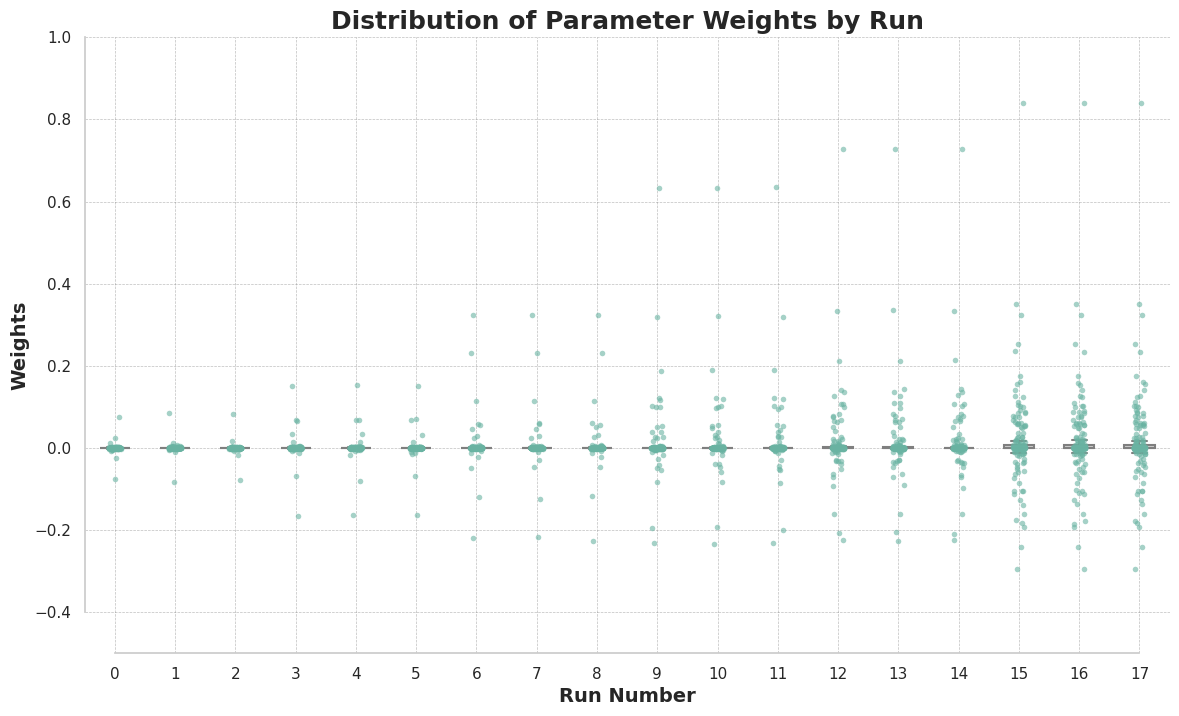

In [56]:

for lbd in lbd_values:
    for run in range(3):  # Run the training 3 times for each lbd
        h_L1 = torch.nn.Linear(
            in_features=n_train,
            out_features=1,
            bias=True
        )
        sigma = torch.nn.Sigmoid()

        f_L1 = torch.nn.Sequential(
            h_L1,
            sigma
        )
        J_BCE = torch.nn.BCELoss()
        GD_optimizer = torch.optim.Adam(lr=0.005, params=f_L1.parameters())

        for i in range(nIter):
            GD_optimizer.zero_grad()
            pred = f_L1(x_parameter_train)
            loss = J_BCE(pred, y_label_train) + L1_reg(f_L1, lbd)
            loss.backward()
            GD_optimizer.step()
            if i == 0 or ((i + 1) % printInterval) == 0:
                print(f'Run {run+1}, Lbd {lbd}, Iter {i+1}: average BCE loss is {loss.item():.3f}')

        with torch.no_grad():
            pred_test = f_L1(x_parameter_test)
        auroc = roc_auc_score(y_label_test, pred_test.squeeze())
        ap = average_precision_score(y_label_test, pred_test.squeeze())

            # Store weights for each run
        weight_L1 = h_L1.weight.detach().squeeze().clone().numpy()
        weights_data.append(weight_L1)
        non_zero_weights = (abs(weight_L1) > 0.02).sum()

        results.append((lbd, run+1, ap, auroc, non_zero_weights))

weights_df = pd.DataFrame(weights_data, columns=[f'Feature_{i}' for i in range(n_train)])

# summary
print("Summary of Results:")
for lbd, run, ap, auroc, non_zero_weights in results:
    print(f'Lbd: {lbd}, Run: {run}, AP: {ap:.3f}, AUROC: {auroc:.3f}, Non-Zero Weights: {non_zero_weights}')


# then we plot the weights optimized from each run
melted_weights_df = weights_df.reset_index().melt(id_vars=['index'])
melted_weights_df.rename(columns={'index': 'Run', 'value': 'Weight'}, inplace=True)

sns.set(style="whitegrid", palette="muted")


plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='Run', y='Weight', data=melted_weights_df, width=0.5, linewidth=1.5, fliersize=0, color='lightgrey')
stripplot = sns.stripplot(x='Run', y='Weight', data=melted_weights_df, size=4, jitter=True, alpha=0.6, color="#69b3a2")

plt.title('Distribution of Parameter Weights by Run', fontsize=18, fontweight='bold')
plt.xlabel('Run Number', fontsize=14, fontweight='bold')
plt.ylabel('Weights', fontsize=14, fontweight='bold')
plt.ylim(-0.5, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
sns.despine(trim=True)

plt.show()

In [58]:
# find out the parameters
weights_data = pd.DataFrame(weights_data)
indices_nonzero = []
for column in weights_data:
    indices = weights_data[column].abs() > 0.02
    if indices.any():
        print(f'{column}:', weights_data.index[indices].tolist())
        indices_nonzero.append(column)

0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1: [15]
2: [9, 10, 11, 12, 13, 14, 15, 16, 17]
4: [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
5: [9, 10, 11, 12, 13, 14, 15, 16, 17]
6: [15, 16, 17]
7: [6, 7, 8, 9, 10, 11, 12, 13, 14]
9: [12, 13, 14, 15, 16, 17]
10: [15, 16, 17]
11: [12, 13, 14]
12: [15, 16, 17]
13: [15, 16, 17]
14: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
15: [15, 16, 17]
16: [12, 13, 14, 15, 16, 17]
17: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
20: [9, 10, 11, 12, 13, 14, 15, 16, 17]
21: [12, 13, 14, 15, 16, 17]
24: [15, 16, 17]
25: [15, 16, 17]
27: [15, 16, 17]
28: [9, 10, 11, 12, 13, 14, 15, 16, 17]
29: [15, 16, 17]
34: [12, 13, 14, 15, 16, 17]
37: [15, 16, 17]
38: [15, 16, 17]
39: [12, 13, 14, 15, 16, 17]
40: [15, 16, 17]
42: [15, 16, 17]
46: [9, 10, 11, 12, 13, 14]
48: [15, 16, 17]
57: [15, 16, 17]
59: [15, 16, 17]
68: [12, 13, 14, 15, 16, 17]
69: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
74: [9, 10, 11, 12, 13, 14, 15, 16, 

In [60]:
for index, row in weights_data.iterrows():

    significant_columns = row.abs() > 0.02

    significant_column_names = significant_columns[significant_columns].index.tolist()

    print(f'Row {index}:', significant_column_names)

Row 0: [0, 4, 86, 153]
Row 1: [0, 153]
Row 2: [0, 153]
Row 3: [0, 4, 85, 86, 153, 157]
Row 4: [0, 4, 85, 86, 153, 157]
Row 5: [0, 4, 85, 86, 153, 157]
Row 6: [0, 4, 7, 14, 17, 69, 85, 86, 96, 128, 153, 157]
Row 7: [0, 4, 7, 14, 17, 69, 85, 86, 96, 128, 153, 157]
Row 8: [0, 4, 7, 14, 17, 69, 85, 86, 96, 128, 153, 157]
Row 9: [0, 2, 4, 5, 7, 14, 17, 20, 28, 46, 69, 74, 75, 82, 85, 87, 96, 128, 153, 154, 157, 186]
Row 10: [0, 2, 4, 5, 7, 14, 17, 20, 28, 46, 69, 74, 75, 82, 85, 87, 96, 128, 153, 154, 157, 186]
Row 11: [0, 2, 4, 5, 7, 14, 17, 20, 28, 46, 69, 74, 75, 82, 85, 87, 96, 128, 153, 154, 157, 186]
Row 12: [0, 2, 4, 5, 7, 9, 11, 14, 16, 17, 20, 21, 28, 34, 39, 46, 68, 69, 74, 75, 82, 83, 85, 87, 90, 96, 125, 128, 153, 154, 157, 186]
Row 13: [0, 2, 4, 5, 7, 9, 11, 14, 16, 17, 20, 21, 28, 34, 39, 46, 68, 69, 74, 75, 82, 83, 85, 87, 90, 96, 125, 128, 153, 154, 157, 186]
Row 14: [0, 2, 4, 5, 7, 9, 11, 14, 16, 17, 20, 21, 28, 34, 39, 46, 68, 69, 74, 75, 82, 83, 85, 87, 90, 96, 125, 128, 

In [105]:

parameter_names = parameter_train.columns.values
parameter_nonzero = parameter_names[indices_nonzero]
target_parameter = np.column_stack((indices_nonzero, parameter_nonzero))
print(target_parameter.shape)
print(target_parameter)

(69, 2)
[[0 'admission_age']
 [1 'heart_rate_min']
 [2 'heart_rate_max']
 [4 'sbp_min']
 [5 'sbp_max']
 [6 'sbp_mean']
 [7 'dbp_min']
 [9 'dbp_mean']
 [10 'mbp_min']
 [11 'mbp_max']
 [12 'mbp_mean']
 [13 'resp_rate_min']
 [14 'resp_rate_max']
 [15 'resp_rate_mean']
 [16 'temperature_min']
 [17 'temperature_max']
 [20 'spo2_max']
 [21 'spo2_mean']
 [24 'glucose_mean']
 [25 'lactate_min']
 [27 'ph_min']
 [28 'ph_max']
 [29 'so2_min']
 [34 'pco2_max']
 [37 'aado2_calc_min']
 [38 'aado2_calc_max']
 [39 'pao2fio2ratio_min']
 [40 'pao2fio2ratio_max']
 [42 'baseexcess_max']
 [46 'totalco2_max']
 [48 'hematocrit_max']
 [57 'chloride_min']
 [59 'calcium_min']
 [68 'hematocrit_max.1']
 [69 'hemoglobin_min.1']
 [74 'wbc_max']
 [75 'albumin_min']
 [76 'albumin_max']
 [81 'aniongap_min']
 [82 'aniongap_max']
 [83 'bicarbote_min.1']
 [84 'bicarbote_max.1']
 [85 'bun_min']
 [86 'bun_max']
 [87 'calcium_min.1']
 [88 'calcium_max.1']
 [90 'chloride_max.1']
 [91 'glucose_min.2']
 [94 'sodium_max.1']
 [9

In [ ]:
# export the training results
weights_data.to_csv('weights_data.csv')
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv')
np.savetxt('target_parameter.csv', target_parameter, delimiter=',', header='index,parameter_name', fmt='%s')


#### Data interpretation from logistic regression + L1

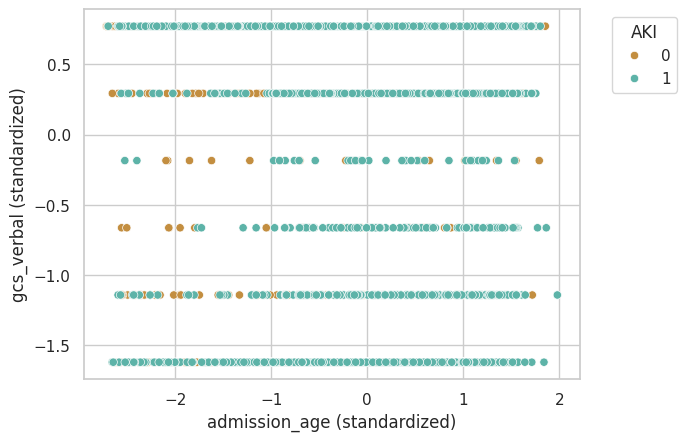

In [ ]:
# plot the labeled data with the top parameters

import matplotlib.pyplot as plt
palette_greenbrown = {0: '#c38e40', 1: '#5db3a8'}
sns.scatterplot(data=df_validation, x=df_validation.iloc[:, 4], y=df_validation.iloc[:, 157], hue=df_validation.iloc[:, 3], palette=palette_greenbrown)
plt.legend(title='AKI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("admission_age (standardized)")
plt.ylabel("gcs_verbal (standardized)")
plt.show()


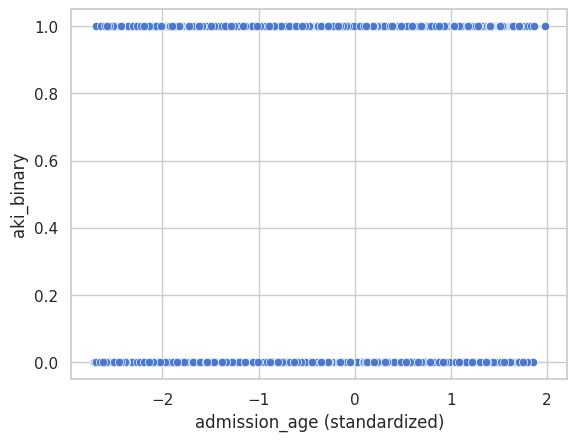

In [ ]:

sns.scatterplot(data=df_validation, x=df_validation.iloc[:, 4], y=df_validation.iloc[:, 3])
plt.xlabel("admission_age (standardized)")
plt.show()


In [ ]:
# create a subset of parameters from above with the training data

parameter_train_L1 = parameter_train.iloc[:, indices_nonzero]
parameter_test_L1 = parameter_test.iloc[:, indices_nonzero]
print(parameter_train_L1.shape)

(28075, 64)


In [ ]:
# we check the correlation

round(parameter_train_L1.apply(parameter_train_L1.corrwith),2)

,admission_age,heart_rate_max,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_mean,mbp_min,mbp_max,mbp_mean,...,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,height,weight_admit,race_BLACK/AFRICAN AMERICAN,race_WHITE,gender_F
admission_age,1.00,-0.15,-0.10,0.13,0.04,-0.30,-0.31,-0.19,0.01,-0.19,...,-0.04,-0.09,-0.02,-0.03,-0.01,-0.12,-0.17,-0.06,0.12,0.07
heart_rate_max,-0.15,1.00,-0.15,0.03,-0.09,0.06,0.18,-0.04,0.11,0.08,...,0.08,-0.05,-0.04,-0.07,-0.04,-0.03,0.00,0.02,-0.04,0.04
sbp_min,-0.10,-0.15,1.00,0.38,0.77,0.57,0.48,0.69,0.15,0.62,...,-0.06,-0.02,0.19,0.20,0.17,0.03,0.05,0.09,-0.04,-0.03
sbp_max,0.13,0.03,0.38,1.00,0.76,0.15,0.34,0.23,0.52,0.55,...,-0.05,-0.11,0.01,-0.06,-0.04,-0.02,0.04,0.08,-0.04,0.00
sbp_mean,0.04,-0.09,0.77,0.76,1.00,0.42,0.52,0.53,0.37,0.76,...,-0.08,-0.09,0.13,0.10,0.08,0.01,0.06,0.11,-0.05,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
height,-0.12,-0.03,0.03,-0.02,0.01,0.08,0.07,0.06,-0.01,0.05,...,0.02,0.03,-0.02,0.00,-0.02,1.00,0.30,-0.01,0.04,-0.46
weight_admit,-0.17,0.00,0.05,0.04,0.06,0.06,0.09,0.05,0.04,0.08,...,0.04,0.09,-0.03,-0.01,-0.01,0.30,1.00,0.04,0.04,-0.27
race_BLACK/AFRICAN AMERICAN,-0.06,0.02,0.09,0.08,0.11,0.09,0.13,0.08,0.05,0.12,...,-0.02,-0.01,0.03,0.04,0.04,-0.01,0.04,1.00,-0.38,0.06
race_WHITE,0.12,-0.04,-0.04,-0.04,-0.05,-0.08,-0.10,-0.05,-0.03,-0.09,...,-0.00,0.02,0.05,0.07,0.06,0.04,0.04,-0.38,1.00,-0.00


#### Logistic Regression with  𝐿2  Regularization (full)

Run 1, Lbd 0.05, Iter 1: average BCE loss is 0.713
Run 1, Lbd 0.05, Iter 1000: average BCE loss is 0.551
Run 1, Lbd 0.05, Iter 2000: average BCE loss is 0.551
Run 1, Lbd 0.05, Iter 3000: average BCE loss is 0.551
Run 1, Lbd 0.05, Iter 4000: average BCE loss is 0.551
Run 1, Lbd 0.05, Iter 5000: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 1: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 1000: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 2000: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 3000: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 4000: average BCE loss is 0.551
Run 2, Lbd 0.05, Iter 5000: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 1: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 1000: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 2000: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 3000: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 4000: average BCE loss is 0.551
Run 3, Lbd 0.05, Iter 5000: average BCE loss is 0.551
Run 1, Lbd 0.01, Iter 1: average BCE 

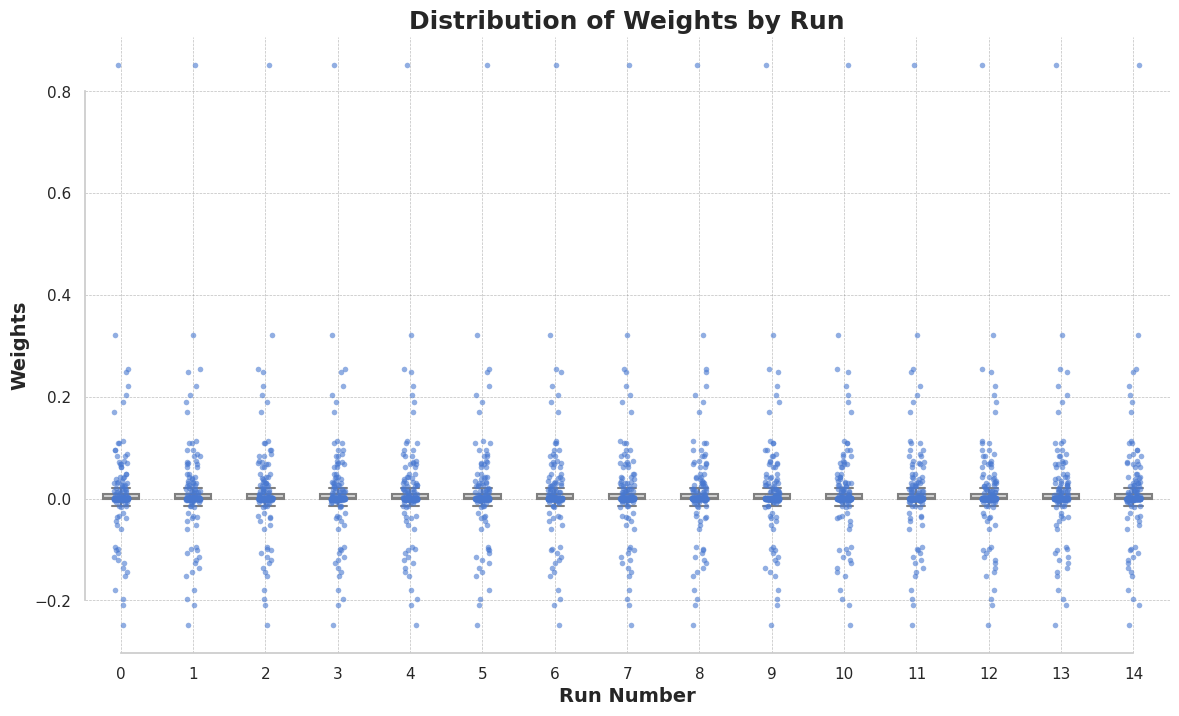

In [ ]:
h_L2 = torch.nn.Linear(
    in_features=n_train,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()


f_L2 = torch.nn.Sequential(
    h_L2,
    sigma
)

J_BCE = torch.nn.BCELoss()


nIter = 5000
printInterval = 1000
lbd_values = [0.05, 0.01, 0.005, 0.001, 0.0005]  # L2 reg strength values to try

results = []  # To store the summary results
weights_data = []  # To collect weights for each run for DataFrame

for lbd in lbd_values:
    for run in range(3):  # Run the training 3 times for each lbd

        GD_optimizer = torch.optim.Adam(lr=0.005, params=f_L2.parameters(),weight_decay=0.05)

        for i in range(nIter):
            GD_optimizer.zero_grad()
            pred = f_L2(x_parameter_train)
            loss = J_BCE(pred, y_label_train)
            loss.backward()
            GD_optimizer.step()
            if i == 0 or ((i + 1) % printInterval) == 0:
                print(f'Run {run+1}, Lbd {lbd}, Iter {i+1}: average BCE loss is {loss.item():.3f}')

        with torch.no_grad():
            pred_test = f_L2(x_parameter_test)
            auroc = roc_auc_score(y_label_test, pred_test.squeeze())
            ap = average_precision_score(y_label_test,pred_test.squeeze())

            # Store weights for each run
            weight_L1 = h_L1.weight.detach().squeeze().clone().numpy()
            weights_data.append(weight_L1)
            non_zero_weights = (weight_L1 > 0.001).sum()

        results.append((lbd, run+1, auroc, ap, non_zero_weights))

weights_df = pd.DataFrame(weights_data, columns=[f'Feature_{i}' for i in range(n_train)])

# Print a summary for all runs with different lbd
print("Summary of Results:")
for lbd, run, auroc, ap, non_zero_weights in results:
    print(f'Lbd: {lbd}, Run: {run}, AUROC: {auroc:.3f},AP: {ap:.3f}, Non-Zero Weights: {non_zero_weights}')


# then we plot the weights optimized from each run
melted_weights_df = weights_df.reset_index().melt(id_vars=['index'])
melted_weights_df.rename(columns={'index': 'Run', 'value': 'Weight'}, inplace=True)

sns.set(style="whitegrid", palette="muted")


plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='Run', y='Weight', data=melted_weights_df, width=0.5, linewidth=1.5, fliersize=0, color='lightgrey')
stripplot = sns.stripplot(x='Run', y='Weight', data=melted_weights_df, size=4, jitter=True, alpha=0.6)

plt.title('Distribution of Weights by Run', fontsize=18, fontweight='bold')
plt.xlabel('Run Number', fontsize=14, fontweight='bold')
plt.ylabel('Weights', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
sns.despine(trim=True)

plt.show()

#### Forward feature selection

In [15]:
model = logit(penalty='l1',C=1/10,solver='liblinear') # c: 1/(strength of L1 regularization)

# Forward feature selection.
forward_selection = SFS(
    model, n_features_to_select=20, direction="forward"
).fit(parameter_train, label_train)

# Backward feature selection.
backward_selection = SFS(
    model, n_features_to_select=20, direction="backward"
).fit(parameter_train, label_train)


KeyboardInterrupt: 

In [ ]:
forward_selection.get_feature_names_out()
backward_selection.get_feature_names_out()

array(['x128', 'x174', 'x175', 'x176', 'x177', 'x178', 'x179', 'x180',
       'x181', 'x182', 'x183', 'x184', 'x185', 'x186', 'x187', 'x188',
       'x189', 'x190', 'x191', 'x192'], dtype=object)

In [ ]:
# Model with forward selected features
model.fit(forward_selection.transform(parameter_train),label_train)
y_pred_FS = model.predict_proba(forward_selection.transform(parameter_test))

# Model with backward selected features
model.fit(backward_selection.transform(parameter_train),label_train)
y_pred_BS = model.predict_proba(backward_selection.transform(parameter_test))

# roc_curve
fpr_FS, tpr_FS, _ = roc_curve(label_test,y_pred_FS[:,1])
fpr_BS, tpr_BS, _ = roc_curve(label_test,y_pred_BS[:,1])

roc_df = pd.DataFrame(
    {
        'False Positive Rate':np.hstack([fpr_FS,fpr_BS]),
        'True Positive Rate':np.hstack([tpr_FS,tpr_BS]),
        'method':['FS']*len(fpr_FS)+['BS']*len(fpr_BS)
    }
)

# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate',facet_col='method',color='method')
fig

#### subset of parameter from feature selection

In [110]:
# training dataset changed
indices_10 = ([0, 4, 7, 14, 69, 85, 86, 96, 153, 157])
parameter_train_10 = parameter_train.iloc[:, indices_10]
parameter_test_10 = parameter_test.iloc[:, indices_10]
#print(parameter_train_10.shape)

indices_19 = ([0, 2, 4, 5, 7, 10, 14, 16, 17, 20, 46, 69, 85, 96, 128, 153, 154, 157])
parameter_train_19 = parameter_train.iloc[:, indices_19]
parameter_test_19 = parameter_test.iloc[:, indices_19]

indices_21 =([0, 2, 4, 5, 7, 10, 14, 16, 17, 20, 28, 46, 69, 85, 86, 96, 125, 128, 153, 154, 157])
parameter_train_21 = parameter_train.iloc[:, indices_21]
parameter_test_21 = parameter_test.iloc[:, indices_21]
parameter_validation_21 = parameter_validation.iloc[:, indices_21]
print(parameter_train_21.shape)

indices_30 = ([0, 2, 4, 5, 7, 10, 11, 14, 15, 16, 17, 20, 28, 39, 46, 68, 69, 75, 82, 85, 87, 90, 96, 125, 127, 128, 153, 154, 157, 186])
parameter_train_30 = parameter_train.iloc[:, indices_30]
parameter_test_30 = parameter_test.iloc[:, indices_30]

(18835, 21)


In [111]:
# for balanced data
indices_22 =([0, 2, 4, 5, 7, 14, 17, 20, 28, 46, 69, 74, 75, 82, 85, 87, 96, 128, 153, 154, 157, 186])
parameter_train_22 = parameter_train.iloc[:, indices_22]
parameter_test_22 = parameter_test.iloc[:, indices_22]
parameter_validation_22 = parameter_validation.iloc[:, indices_22]
print(parameter_train_22.shape)


(18835, 22)


#### SVM (it seems the parameters very likely contributing to the prediction in a nonlinear way)

In [62]:
parameters_SVM = {
    'C':np.arange(0.2,5,step=0.2)
}
stratifiedCV = StratifiedKFold(n_splits=5)

SVCModel = SVC(kernel='rbf')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters_SVM,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(parameter_train_22,label_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
       2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8])},
             scoring='f1', verbose=1)

In [63]:
BestSVC.best_estimator_

SVC(C=0.2)

In [64]:
BestSVC.best_score_

0.6851987968395107

In [119]:
y_pred = BestSVC.predict(parameter_test_22)
print('F1 score on test set: {:.4f}'.format(f1_score(label_test,y_pred)))
crossvali_table = pd.crosstab(label_test,y_pred)

TN = crossvali_table.loc[0, 0]
FP = crossvali_table.loc[0, 1]
FN = crossvali_table.loc[1, 0]
TP = crossvali_table.loc[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")

F1 score on test set: 0.6725
False Positive Rate: 0.3255523134639433
False Negative Rate: 0.3221476510067114


In [120]:
crossvali_table

col_0,0,1
aki_binary,,
0,3236,1562
1,1488,3131


In [ ]:
model_path_SVM = '/content/drive/MyDrive/ColabData/best_SVM_model.pkl'

# Save the model
with open(model_path_SVM, 'wb') as file:
    pickle.dump(BestSVC, file)


#### Tree models (XGBoost)

In [112]:
# try with 21 parameters first

parameters_XG = {
    'n_estimators':np.arange(start=5,stop=15,step=2),
    'max_depth':np.arange(start=2,stop=9,step=1),
    'learning_rate':np.arange(start=0.01,stop=0.1,step=0.01)
}

In [113]:
# 21 parameters
stratifiedCV = StratifiedKFold(n_splits=5)

XGBoostModel = XGBC()
BestXGBoost_bal = GridSearchCV(
    XGBoostModel,
    param_grid=parameters_XG,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestXGBoost_bal.fit(parameter_train_22,label_train)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                         'n_estimators': array([ 5,  7,  9, 11, 13])},
             scoring='f1', verbose=1)

In [114]:
BestXGBoost_bal.best_params_

{'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 13}

In [115]:
BestXGBoost_bal.best_score_

0.6668004558338803

In [117]:
y_pred = BestXGBoost_bal.predict(parameter_test_22)
print('F1 score on test set: {:.4f}'.format(f1_score(label_test,y_pred)))
pd.crosstab(label_test,y_pred)

F1 score on test set: 0.6615


col_0,0,1
aki_binary,,
0,3329,1469
1,1610,3009


In [118]:
crossvali_table = pd.crosstab(label_test,y_pred)

TN = crossvali_table.loc[0, 0]
FP = crossvali_table.loc[0, 1]
FN = crossvali_table.loc[1, 0]
TP = crossvali_table.loc[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")

False Positive Rate: 0.3061692371821592
False Negative Rate: 0.3485602944360251


In [ ]:
model_path_XGBoost = '/content/drive/MyDrive/ColabData/best_XGBoost_model.pkl'

# Save the model
with open(model_path_XGBoost, 'wb') as file:
    pickle.dump(BestXGBoost, file)


In [ ]:
model_path_XGBoost = '/content/drive/MyDrive/ColabData/best_XGBoost_model.pkl'
with open(model_path_XGBoost, 'rb') as file:
    loaded_XGBoost_model = pickle.load(file)
    BestXGBoost = loaded_XGBoost_model

#### Decision tree

In [ ]:
parameters_DT = {'max_depth':np.arange(start=1,stop=10,step=1)}
parameters_DT

{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [ ]:
stratifiedCV = StratifiedKFold(n_splits=7)
TreeModel = DTC(criterion='entropy')
BestTree = GridSearchCV(
    TreeModel,
    param_grid=parameters_DT,
    scoring='f1',
    cv=stratifiedCV
)
BestTree.fit(parameter_train_21,label_train)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [ ]:
BestTree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [ ]:
BestTree.best_score_

0.7938478685121021

In [ ]:
y_pred = BestTree.predict(parameter_test_21)
print('F1 score on test set: {:.4f}'.format(f1_score(label_test,y_pred)))
pd.crosstab(label_test,y_pred)

F1 score on test set: 0.7938


col_0,1
aki_binary,
0,4798
1,9238


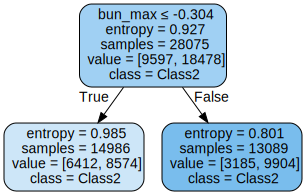

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

best_model = BestTree.best_estimator_

dot_data = export_graphviz(best_model, out_file=None,
                           feature_names=parameter_train_21.columns,
                           class_names=['Class1', 'Class2'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph


In [ ]:
model_path_DT = '/content/drive/MyDrive/ColabData/best_DT_model.pkl'

# Save the model
with open(model_path_DT, 'wb') as file:
    pickle.dump(best_model, file)



#### Ensemble learning

In [ ]:
# set the output for the logistic regression model as one parameter, assembly the training data and testing data
# the training data for ensemble learning is the original testing data computed through the three models
# the testing data for ensemble learning is the original validation data computed through the three models

# testing -> training
train_parameter_SVM = BestSVC.predict(parameter_test_21)
train_parameter_XGBoost = BestXGBoost.predict(parameter_test_21)

LG_pred_test = f_L1(x_parameter_test)
train_parameter_LG = LG_pred_test.detach().numpy().squeeze()

parameter_train_hyper = np.column_stack((train_parameter_SVM, train_parameter_XGBoost, train_parameter_LG))

# validation -> testing
test_parameter_SVM = BestSVC.predict(parameter_validation_21)
test_parameter_XGBoost = BestXGBoost.predict(parameter_validation_21)

LG_pred_validation = f_L1(x_parameter_validation)
test_parameter_LG = LG_pred_validation.detach().numpy().squeeze()

parameter_test_hyper = np.column_stack((test_parameter_SVM, test_parameter_XGBoost, test_parameter_LG))

In [ ]:
train_hyper = np.column_stack((train_parameter_SVM, train_parameter_XGBoost, train_parameter_LG,label_test))

df_train_hyper = pd.DataFrame(train_hyper, columns=['SVM', 'XGBoost', 'Logistic&L1', 'Label'])


df_train_hyper['Label'] = df_train_hyper['Label'].map({0: 'no AKF', 1: 'AKF'})

# Now, plot with px.scatter_3d and the updated legend
fig = px.scatter_3d(df_train_hyper, x='SVM', y='XGBoost', z='Logistic&L1', color='Label', size_max=5)

# Update the legend title
fig.update_layout(legend_title_text='Class')

fig.show()

##### XGBoost

In [ ]:
#
parameters_ES = {
    'n_estimators':np.arange(start=2,stop=5,step=1),
    'max_depth':np.arange(start=2,stop=3,step=1),
    'learning_rate':np.arange(start=0.01,stop=0.05,step=0.01)
}


stratifiedCV = StratifiedKFold(n_splits=5)

XGBoostModel = XGBC()
BestXGBoost_ES = GridSearchCV(
    XGBoostModel,
    param_grid=parameters_ES,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestXGBoost_ES.fit(parameter_train_hyper,label_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                         'max_depth': array([2]),
                         'n_estimators': array([2, 3, 4])},
             scoring='f1', verbose=1)

In [ ]:
BestXGBoost_ES.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2}

In [ ]:
BestXGBoost_ES.best_score_

0.7938472024584963

In [ ]:
y_pred = BestXGBoost_ES.predict(parameter_test_hyper)
print('F1 score on test set: {:.4f}'.format(f1_score(label_validation,y_pred)))
pd.crosstab(label_validation,y_pred)

F1 score on test set: 0.7938


col_0,1
aki_binary,
0,1600
1,3079


##### Simple tree

In [ ]:
parameters_DT_ES = {'max_depth':np.arange(start=3,stop=4,step=1)}

stratifiedCV = StratifiedKFold(n_splits=7)
TreeModel = DTC(criterion='entropy')
BestTree_ES = GridSearchCV(
    TreeModel,
    param_grid=parameters_DT_ES,
    scoring='f1',
    cv=stratifiedCV
)
BestTree_ES.fit(parameter_train_hyper,label_test)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([3])}, scoring='f1')

In [ ]:
BestTree_ES.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
BestTree_ES.best_score_

0.810196522510546

In [ ]:
y_pred = BestTree_ES.predict(parameter_test_hyper)
print('F1 score on test set: {:.4f}'.format(f1_score(label_validation,y_pred)))
pd.crosstab(label_validation,y_pred)

F1 score on test set: 0.8076


col_0,0,1
aki_binary,,
0,657,943
1,355,2724


In [ ]:
crossvali_table = pd.crosstab(label_validation,y_pred)

TN = crossvali_table.loc[0, 0]
FP = crossvali_table.loc[0, 1]
FN = crossvali_table.loc[1, 0]
TP = crossvali_table.loc[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")

False Positive Rate: 0.589375
False Negative Rate: 0.11529717440727509


In [106]:

best_model = BestTree_ES.best_estimator_

dot_data = export_graphviz(best_model, out_file=None,
                           class_names=['no AKF', 'AKF'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

NameError: name 'BestTree_ES' is not defined

##### SVM

In [ ]:
parameters_SVM_ES = {
    'C':np.arange(0.2,5,step=0.2)
}
stratifiedCV = StratifiedKFold(n_splits=5)

SVCModel = SVC(kernel='rbf')
BestSVC_ES = GridSearchCV(
    SVCModel,
    param_grid=parameters_SVM_ES,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC_ES.fit(parameter_train_hyper,label_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
       2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8])},
             scoring='f1', verbose=1)

In [ ]:
BestSVC_ES.best_estimator_

SVC(C=0.4)

In [ ]:
BestSVC_ES.best_score_

0.8125971038934423

In [ ]:
y_pred = BestSVC_ES.predict(parameter_test_hyper)
print('F1 score on test set: {:.4f}'.format(f1_score(label_validation,y_pred)))
crossvali_table = pd.crosstab(label_validation,y_pred)

TN = crossvali_table.loc[0, 0]
FP = crossvali_table.loc[0, 1]
FN = crossvali_table.loc[1, 0]
TP = crossvali_table.loc[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
crossvali_table

F1 score on test set: 0.8062
False Positive Rate: 0.635625
False Negative Rate: 0.10165638194218903


col_0,0,1
aki_binary,,
0,583,1017
1,313,2766


##### simple L1

In [ ]:
# convert the hyper input into pytorch tensor

x_hyper = torch.tensor(parameter_train_hyper, dtype=torch.float32)
m_hyper,n_hyper = x_hyper.shape
y_hyper = torch.tensor(label_test, dtype=torch.float32).reshape(m_hyper,1)

x_test = torch.tensor(parameter_test_hyper, dtype=torch.float32)
y_test = torch.tensor(label_validation, dtype=torch.float32).reshape(len(label_validation),1)


In [ ]:
h = torch.nn.Linear(
    in_features=n_hyper,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()


f = torch.nn.Sequential(
    h,
    sigma
)

J_BCE = torch.nn.BCELoss()

GD_optimizer = torch.optim.Adam(lr=0.01,params=f.parameters())

nIter = 5000
printInterval = 1000

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f(x_hyper)
    loss = J_BCE(pred,y_hyper)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f(x_test)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.698
Iter 1000: average BCE loss is 0.548
Iter 2000: average BCE loss is 0.546
Iter 3000: average BCE loss is 0.546
Iter 4000: average BCE loss is 0.546
Iter 5000: average BCE loss is 0.546
On test dataset: AUROC 0.751, AP 0.842


In [ ]:
print(h.weight.detach().squeeze().clone())

tensor([0.1963, 0.1135, 4.6700])


##### binary classification

In [ ]:
df_hyper = pd.DataFrame(train_hyper, columns=['SVM', 'XGBoost', 'Logistic&L1', 'Label'])

conditions = [
    (1, 1),  # (SVM, XGBoost)
    (1, 0),
    (0, 0),
    (0, 1)
]
df_hyper_subsets = {}

for i, (svm_val, xgb_val) in enumerate(conditions):

    subset = df_hyper[(df_hyper['SVM'] == svm_val) & (df_hyper['XGBoost'] == xgb_val)]
    df_hyper_subsets[f'Subset_{i+1}'] = subset


In [ ]:
lg_val_subset1 = None
lg_val_subset2 = None
lg_val_subset3 = None
lg_val_subset4 = None

best_accuracy_1 = 0
best_accuracy_2 = 0
best_accuracy_3 = 0
best_accuracy_4 = 0

for lg_value in np.linspace(0, 1, 2000):
        predicted_labels = (df_hyper_subsets['Subset_1']['Logistic&L1'] < lg_value).astype(int)

        # Calculate accuracy
        accuracy = (predicted_labels == df_hyper_subsets['Subset_1']['Label']).mean()

        if accuracy > best_accuracy_1:
            lg_val_subset1  = lg_value
            best_accuracy_1 = accuracy

for lg_value in np.linspace(0, 1, 2000):
  predicted_labels = (df_hyper_subsets['Subset_2']['Logistic&L1'] > lg_value).astype(int)
  accuracy = (predicted_labels == df_hyper_subsets['Subset_2']['Label']).mean()
  if accuracy > best_accuracy_2:
    lg_val_subset2 = lg_value
    best_accuracy_2 = accuracy

for lg_value in np.linspace(0, 1, 2000):
  predicted_labels = (df_hyper_subsets['Subset_3']['Logistic&L1'] > lg_value).astype(int)
  accuracy = (predicted_labels == df_hyper_subsets['Subset_3']['Label']).mean()
  if accuracy > best_accuracy_3:
    lg_val_subset3 = lg_value
    best_accuracy_3 = accuracy

for lg_value in np.linspace(0, 1, 2000):
  predicted_labels = (df_hyper_subsets['Subset_4']['Logistic&L1'] > lg_value).astype(int)
  accuracy = (predicted_labels == df_hyper_subsets['Subset_4']['Label']).mean()
  if accuracy > best_accuracy_4:
    lg_val_subset4 = lg_value
    best_accuracy_4 = accuracy




In [ ]:
print([best_accuracy_1,lg_val_subset1])
print([best_accuracy_2,lg_val_subset2])
print([best_accuracy_3,lg_val_subset3])
print([best_accuracy_4,lg_val_subset4])


[0.7358358182774952, 0.9979989994997498]
[0.6075949367088608, 0.4997498749374687]
[0.7510656436487638, 0.48324162081040517]
[0.6353111432706223, 0.5192596298149074]


In [ ]:
def classify_ES(data, lg_thresholds):
    predicted_y = pd.Series([None] * data.shape[0], index=data.index)

    scenarios = {
        'Subset_1': (1, 1),
        'Subset_2': (1, 0),
        'Subset_3': (0, 0),
        'Subset_4': (0, 1)
    }

    for scenario_key, (svm_val, xgb_val) in scenarios.items():

        subset_indices = data[(data['SVM'] == svm_val) & (data['XGBoost'] == xgb_val)].index


        if subset.empty or scenario_key not in lg_thresholds:
            print(f"No data or threshold not defined for {scenario_key}. Skipping.")
            continue

        threshold = lg_thresholds[scenario_key]

        if scenario_key == 'Subset_1':
            predicted_labels = (data.loc[subset_indices, 'Logistic&L1'] < threshold).astype(int)
        else:
            predicted_labels = (data.loc[subset_indices, 'Logistic&L1'] > threshold).astype(int)


        #predicted_labels = (data.loc[subset_indices, 'Logistic&L1'] > threshold).astype(int)

        predicted_y.loc[subset_indices] = predicted_labels

    return predicted_y



lg_thresholds = {
    'Subset_1': lg_val_subset1,
    'Subset_2': lg_val_subset2,
    'Subset_3': lg_val_subset3,
    'Subset_4': lg_val_subset4
}



parameter_test_hyper_df = pd.DataFrame(parameter_test_hyper, columns=['SVM', 'XGBoost', 'Logistic&L1'])
pre_Y = classify_ES(parameter_test_hyper_df, lg_thresholds)




In [ ]:

crossvali_table = pd.crosstab(label_validation,pre_Y)

TN = crossvali_table.loc[0, 0]
FP = crossvali_table.loc[0, 1]
FN = crossvali_table.loc[1, 0]
TP = crossvali_table.loc[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
crossvali_table

False Positive Rate: 0.649375
False Negative Rate: 0.08898993179603767


col_0,0,1
aki_binary,,
0,561,1039
1,274,2805
